In [65]:
import sys, os, random
import csv
import json
import numpy as np
import matplotlib.pyplot as plt
import openai
from datasets import load_dataset
from collections import defaultdict, OrderedDict
import shutil
import ast, re, copy
import uuid
from tqdm import tqdm
from mypy import api as mypyapi
import subprocess
import mistune
import sqlite3
import sqlparse
from pathlib import Path

In [2]:
database_path = "./main.sqlite"

In [ ]:
# doesn't work well
def standardize_schema(database_path):
    # Connect to the SQLite database
    conn = sqlite3.connect(database_path)
    cursor = conn.cursor()
    
    # Fetch the raw schema
    cursor.execute("SELECT sql FROM sqlite_master WHERE type IN ('table', 'index', 'view', 'trigger')")
    raw_schema = cursor.fetchall()
    
    # Standardize each SQL statement
    standardized_schema = []
    for sql in raw_schema:
        if sql[0]:  # Make sure there is a SQL statement
            # Format the SQL statement with sqlparse
            formatted_sql = sqlparse.format(sql[0], reindent=True, compact=True, keyword_case='upper')
            standardized_schema.append(formatted_sql)
    
    # Close the database connection
    conn.close()
    
    # Output the standardized schema
    return "\n\n".join(standardized_schema)

In [3]:
alice_system_message = \
"""You are an expert computer scientist. Your task is to take a Python 3.10 program and write a similar program which is not semantically equivalent, which means that there must exist at least a diverging input example such that the original program and your program either produce different outputs or exceptions, or one halts and the other one does not halt. In addition to a program, you need to produce a diverging input example. Start by carefully analyzing the original program and think of how an example would propagate through it from the input to the return value, considering how to modify the program in order to elicit a different behavior. Make sure that the return values or exceptions raised by your program are picklable.
The original program and your program will be used in a test to evaluate the skill of an expert computer scientist who will have to produce a diverging example (not necessarily the same as yours), so make sure that the difference you introduce are not very easy to understand. You will be given a difficulty level from 0 (easiest) to 10 (hardest) to target. E.g. difficulty level 0 means that an expert computer scientist in the bottom decile or above should be able to find a diverging example, difficulty level 9 means that only an expert computer scientist in the top decile should be able to find a diverging example, and difficulty level 10 means that only the top 1% or less of expert computer scientists should be able to find a diverging example.
Think step by step before writing your program. Use the following Markdown format, making sure that the following sections are delimited by level 1 headings, since they will have to be automatically parsed:
# Analysis
step by step analysis. This section can include sub-headings and code blocks
# Generated program
your program inside a Python code block. Do not change the name or signature of the entry point function
# Diverging input example
your diverging input example as a Python dictionary inside a Python code block
For instance, if the entry point function takes two parameters a and b and your diverging example is a="foo" and b=42, write:
```python
{
  "a": "foo",
  "b": 42
}
```
do not write the expected outputs
"""

bob_system_message = \
"""You are an expert computer scientist. Your task is to take two Python 3.10 programs and determine whether or not they are semantically equivalent. Two programs are semantically equivalent if there exists no diverging input examples such that the original program and your program either produce different outputs or exceptions, or one halts and the other one does not halt. If you determine that the two programs are not semantically equivalent, you also need to produce a diverging input example. Start by carefully analyzing the two programs and think of how an example would propagate through them from the input to the return value, considering whether it could elicit a different behaviors. 
Think step by step before writing your program. Use the following Markdown format, making sure that the following sections are delimited by level 1 headings, since they will have to be automatically parsed:
# Analysis
step by step analysis. This section can include sub-headings and code blocks
# Equivalent?
Yes or No
# Diverging input example
your diverging input example as a Python dictionary inside a Python code block, or nothing if the two programs are equivalent.
For instance, if the entry point function takes two parameters a and b and your diverging example is a="foo" and b=42, write:
```python
{
  "a": "foo",
  "b": 42
}
```
do not write the expected outputs
"""

In [4]:
conn = sqlite3.connect(database_path)
cursor = conn.cursor()

cursor.execute("INSERT OR IGNORE INTO system_message (message) VALUES (?)", (alice_system_message,))
cursor.execute("SELECT oid FROM system_message WHERE message = ?", (alice_system_message,))
alice_system_message_id = cursor.fetchone()[0]
cursor.execute("INSERT OR IGNORE INTO system_message (message) VALUES (?)", (bob_system_message,))
cursor.execute("SELECT oid FROM system_message WHERE message = ?", (bob_system_message,))
bob_system_message_id = cursor.fetchone()[0]

conn.commit()
conn.close()

In [5]:
conn.close()

In [6]:
conn = sqlite3.connect(database_path)
cursor = conn.cursor()

cursor.execute("INSERT INTO dataset (name, split) VALUES (?, ?)", ("mbpp", "train"))
cursor.execute("INSERT INTO dataset (name, split) VALUES (?, ?)", ("mbpp", "test"))

conn.commit()
conn.close()

IntegrityError: UNIQUE constraint failed: dataset.name, dataset.split

In [7]:
# Insert base examples

conn = sqlite3.connect(database_path)
dataset_cursor = conn.cursor()

dataset_cursor.execute("SELECT oid, name, split FROM dataset")
dataset_rows = dataset_cursor.fetchall()
for row in dataset_rows:
    dataset_id, dataset_name, dataset_split = row
    print(dataset_id, dataset_name, dataset_split)
    dataset_full = load_dataset(dataset_name)
    data = dataset_full[dataset_split]
    data = [dict(example) for example in data]
    print(f"Examples: {len(data)}")
    for example in data:
        function_name = ast.parse(example["test_list"][0]).body[0].test.left.func.id
        example["function_name"] = function_name
        example["test_list_str"] = str(example["test_list"])
        example["challenge_test_list_str"] = str(example["challenge_test_list"])
        example["dataset_id"] = dataset_id
        example_cursor = conn.cursor()
        example_cursor.execute("INSERT INTO example (task_id, text, code, test_list_str, test_setup_code, challenge_test_list_str, function_name, dataset_id) VALUES (:task_id, :text, :code, :test_list_str, :test_setup_code, :challenge_test_list_str, :function_name, :dataset_id)", example)
conn.commit()
conn.close()

1 mbpp train
Examples: 374
2 mbpp test
Examples: 500


In [6]:
# Insert Alice's generations

In [7]:
#alice_config = {"round_n": 0, "run_n": 0, "mode": "base_0_shot", "model_provider": "openai", "model": "gpt-4o-mini-2024-07-18", "temperature": 1.0, "top_p": 0.7, "max_tokens": 2048, "n": 10, "previous_round_id" : None, "finetuning_from_bob_filename": None, "finetuning_from_bob_config_id": None}
#alice_config = {"round_n": 0, "run_n": 1, "mode": "base_0_shot", "model_provider": "openai", "model": "gpt-4o-mini-2024-07-18", "temperature": 1.0, "top_p": 0.7, "max_tokens": 2048, "n": 10, "previous_round_id" : None, "finetuning_from_bob_filename": None, "finetuning_from_bob_config_id": None}
#alice_config = {"round_n": 1, "run_n": 0, "mode": "base_0_shot", "model_provider": "openai", "model": "ft:gpt-4o-mini-2024-07-18:uedin:semantic-inequiv-alice-run-0-round-0:AHFhDD6I", "temperature": 1.0, "top_p": 0.7, "max_tokens": 2048, "n": 10, "previous_round_id" : 1, "finetuning_from_bob_filename": "./finetuning_data_for_alice/finetuning_data_for_alice_0_train_0.jsonl", "finetuning_from_bob_config_id": 1}
#alice_config = {"round_n": 1, "run_n": 1, "mode": "base_0_shot", "model_provider": "openai", "model": "ft:gpt-4o-mini-2024-07-18:uedin:semantic-inequiv-alice-run-1-round-0:AIf2wVxd", "temperature": 1.0, "top_p": 0.7, "max_tokens": 2048, "n": 10, "previous_round_id" : 1, "finetuning_from_bob_filename": "./finetuning_data_for_alice/finetuning_data_for_alice_0_train_1.jsonl", "finetuning_from_bob_config_id": 1}
#alice_config = {"round_n": 1, "run_n": 2, "mode": "base_0_shot", "model_provider": "openai", "model": "ft:gpt-4o-mini-2024-07-18:uedin:semantic-inequiv-alice-run-2-round-0:AJ3BKMSO", "temperature": 1.0, "top_p": 0.7, "max_tokens": 2048, "n": 10, "previous_round_id" : 1, "finetuning_from_bob_filename": "./finetuning_data_for_alice/finetuning_data_for_alice_0_train_2.jsonl", "finetuning_from_bob_config_id": 3}
#alice_config = {"round_n": 2, "run_n": 0, "mode": "base_0_shot", "model_provider": "openai", "model": "ft:gpt-4o-mini-2024-07-18:uedin:semantic-inequiv-alice-run-0-round-1:AKsO2x9L", "temperature": 1.0, "top_p": 0.7, "max_tokens": 2048, "n": 10, "previous_round_id" : 1, "finetuning_from_bob_filename": "./finetuning_data_for_alice/finetuning_data_for_alice_1_train_0.jsonl", "finetuning_from_bob_config_id": 4}
#alice_config = {"round_n": 3, "run_n": 0, "mode": "base_0_shot", "model_provider": "openai", "model": "ft:gpt-4o-mini-2024-07-18:uedin:semantic-inequiv-alice-run-0-round-2:AKxe9TmB", "temperature": 1.0, "top_p": 0.7, "max_tokens": 2048, "n": 10, "previous_round_id" : 1, "finetuning_from_bob_filename": "./finetuning_data_for_alice/finetuning_data_for_alice_2_train_0.jsonl", "finetuning_from_bob_config_id": 5}
#alice_config = {"round_n": 4, "run_n": 0, "mode": "base_0_shot", "model_provider": "openai", "model": "ft:gpt-4o-mini-2024-07-18:uedin:semantic-inequiv-alice-run-0-round-3:Adfdi05r", "temperature": 1.0, "top_p": 0.7, "max_tokens": 2048, "n": 10, "previous_round_id" : 1, "finetuning_from_bob_filename": "./finetuning_data_for_alice/finetuning_data_for_alice_3_train_0.jsonl", "finetuning_from_bob_config_id": 6}
#alice_config = {"round_n": 5, "run_n": 0, "mode": "base_0_shot", "model_provider": "openai", "model": "ft:gpt-4o-mini-2024-07-18:uedin:semantic-inequiv-alice-run-0-round-4:AfXtDlh5", "temperature": 1.0, "top_p": 0.7, "max_tokens": 2048, "n": 10, "previous_round_id" : 1, "finetuning_from_bob_filename": "./finetuning_data_for_alice/finetuning_data_for_alice_4_train_0.jsonl", "finetuning_from_bob_config_id": 7}
#alice_config = {"round_n": 6, "run_n": 0, "mode": "base_0_shot", "model_provider": "openai", "model": "ft:gpt-4o-2024-08-06:uedin:semantic-inequiv-alice-run-0-round-5-dpo:Aq5l34VS", "temperature": 1.0, "top_p": 0.7, "max_tokens": 2048, "n": 10, "previous_round_id" : 1, "finetuning_from_bob_filename": "finetuning_data_for_alice_dpo_5_train_0.jsonl", "finetuning_from_bob_config_id": 6}
alice_config = {"round_n": 6, "run_n": 1, "mode": "base_0_shot", "model_provider": "openai", "model": "ft:gpt-4o-mini-2024-07-18:uedin:semantic-inequiv-alice-run-0-round-5:Aphr2tfR", "temperature": 1.0, "top_p": 0.7, "max_tokens": 2048, "n": 10, "previous_round_id" : 1, "finetuning_from_bob_filename": "finetuning_data_for_alice_dpo_5_train_0.jsonl", "finetuning_from_bob_config_id": 6}
alice_data_filename = f"./alice_train_round_{alice_config['round_n']}_{alice_config['run_n']}.jsonl"
alice_target_difficulty_level = 10

conn = sqlite3.connect(database_path)
cursor = conn.cursor()

cursor.execute("INSERT OR IGNORE INTO alice_config (round_n, run_n, mode, model_provider, model, temperature, top_p, max_tokens, n, finetuning_from_bob_filename, finetuning_from_bob_config_id) VALUES (:round_n, :run_n, :mode, :model_provider, :model, :temperature, :top_p, :max_tokens, :n, :finetuning_from_bob_filename, :finetuning_from_bob_config_id)", alice_config)

conn.commit()
conn.close()

In [8]:
conn = sqlite3.connect(database_path)
cursor = conn.cursor()

cursor.execute("SELECT oid FROM alice_config WHERE round_n = ? AND run_n = ?", (alice_config['round_n'], alice_config['run_n']))
alice_config_id = cursor.fetchone()[0]
print(f"alice_config_id: {alice_config_id}")

conn.close()

alice_config_id: 11


In [9]:
# load generations

alice_data_filename = f"./bob_train_round_{alice_config['round_n']}_{alice_config['run_n']}.jsonl"

data = list()
with open(alice_data_filename, "r") as in_fs:
    for line in in_fs:
        example = json.loads(line.strip())
        new_example = defaultdict(list)
        new_example.update(example)
        new_example["bad_evaluations"] = []
        new_example["test_correct_programs"] = []
        for program in example["test_correct_programs"]:
            new_program = defaultdict(list)
            new_program.update(program)
            new_example["test_correct_programs"].append(new_program)
        data.append(new_example)

In [10]:
data[0].keys()

dict_keys(['task_id', 'text', 'code', 'test_list', 'test_setup_code', 'challenge_test_list', 'function_name', 'user_message', 'test_correct_programs', 'new_raw_programs_and_examples', 'raw_programs_and_examples', 'new_programs_and_examples', 'programs_and_examples', 'bad_evaluations', 'test_correct_evaluations', 'bad_programs'])

In [267]:
conn = sqlite3.connect(database_path)
cursor = conn.cursor()

dataset_cursor = conn.cursor()
dataset_cursor.execute("SELECT oid, split FROM dataset WHERE name = ? AND split = ?", ("mbpp", "train"))
dataset_id = dataset_cursor.fetchone()[0]

for example in data:
    example["test_list_str"] = str(example["test_list"])
    example["challenge_test_list_str"] = str(example["challenge_test_list"])
    example["dataset_id"] = dataset_id
    example_cursor = conn.cursor()
    example_cursor.execute(
        "SELECT oid FROM example WHERE task_id = ? AND text = ? AND code = ? AND test_list_str = ? AND test_setup_code = ? AND challenge_test_list_str = ? AND function_name = ? AND dataset_id = ?",
        (example["task_id"],
         example["text"],
         example["code"],
         example["test_list_str"],
         example["test_setup_code"],
         example["challenge_test_list_str"],
         example["function_name"],
         example["dataset_id"]))
    example_id = example_cursor.fetchone()[0]
    example["example_id"] = example_id

    cursor = conn.cursor()
    cursor.execute(
        "INSERT INTO alice_query_to_llm (example_id, alice_config_id, system_message_id, user_message, target_difficulty_level) VALUES (?, ?, ?, ?, ?)",
        (example_id, alice_config_id, alice_system_message_id, example["user_message"], alice_target_difficulty_level)
    )
    query_id = cursor.lastrowid
    for llm_generation in example["new_raw_programs_and_examples"]:
        x = llm_generation.copy()
        x["query_id"] = query_id
        x["is_parsable"] =  (llm_generation["id"] in [y["id"] for y in example['new_programs_and_examples']])
        x["is_correct"]  =  (llm_generation["id"] in [y["id"] for y in example['test_correct_programs']])

        if x["is_correct"]:
            correct_parsed_program = [y["program"] for y in example['test_correct_programs'] if y["id"] == llm_generation["id"]][0]
            generated_program_cursor = conn.cursor()
            generated_program_cursor.execute(
                "INSERT OR IGNORE INTO generated_program (example_id, program, added_on_alice_round, added_on_alice_run) VALUES (?, ?, ?, ?)", 
                (example_id, correct_parsed_program, alice_config["round_n"], alice_config["run_n"]))
            generated_program_cursor.execute(
                "SELECT oid FROM generated_program WHERE example_id = ? AND program = ?",
                (example_id, correct_parsed_program))
            correct_program_id = generated_program_cursor.fetchone()[0]
        else:
            correct_program_id = None
        x["correct_program_id"] = correct_program_id
        llm_response_cursor = conn.cursor()
        llm_response_cursor.execute(
            "INSERT INTO alice_llm_response (query_id, id, llm_response, program, diverging_input_example, is_parsable, is_correct, correct_program_id) VALUES (:query_id, :id, :llm_response, :program, :diverging_input_example, :is_parsable, :is_correct, :correct_program_id)",
            x)
conn.commit()
conn.close()

In [73]:
conn.close()

In [251]:
# Insert Bob's evaluations

In [9]:
#bob_config = {"round_n": 0, "run_n": 0, "mode": "base_eval_0_shot", "model_provider": "openai", "model": "gpt-4o-mini-2024-07-18", "temperature": 1.0, "top_p": 0.7, "max_tokens": 2048, "n": 10, "alice_config_id": 1}
#bob_config = {"round_n": 1, "run_n": 0, "mode": "base_eval_0_shot", "model_provider": "openai", "model": "gpt-4o-mini-2024-07-18", "temperature": 1.0, "top_p": 0.7, "max_tokens": 2048, "n": 10, "alice_config_id": 3, "previous_round_id": 1}
#bob_config = {"round_n": 1, "run_n": 1, "mode": "base_eval_0_shot", "model_provider": "openai", "model": "gpt-4o-mini-2024-07-18", "temperature": 1.0, "top_p": 0.7, "max_tokens": 2048, "n": 10, "alice_config_id": 3, "previous_round_id": 1}
#bob_config = {"round_n": 1, "run_n": 2, "mode": "base_eval_0_shot", "model_provider": "openai", "model": "gpt-4o-mini-2024-07-18", "temperature": 1.0, "top_p": 0.7, "max_tokens": 2048, "n": 10, "alice_config_id": 3, "previous_round_id": 1}
#bob_config = {"round_n": 2, "run_n": 0, "mode": "base_eval_0_shot", "model_provider": "openai", "model": "gpt-4o-mini-2024-07-18", "temperature": 1.0, "top_p": 0.7, "max_tokens": 2048, "n": 10, "alice_config_id": 6, "previous_round_id": 4}
#bob_config = {"round_n": 3, "run_n": 0, "mode": "base_eval_0_shot", "model_provider": "openai", "model": "gpt-4o-mini-2024-07-18", "temperature": 1.0, "top_p": 0.7, "max_tokens": 2048, "n": 10, "alice_config_id": 7, "previous_round_id": 5}
#bob_config = {"round_n": 4, "run_n": 0, "mode": "base_eval_0_shot", "model_provider": "openai", "model": "gpt-4o-mini-2024-07-18", "temperature": 1.0, "top_p": 0.7, "max_tokens": 2048, "n": 10, "alice_config_id": 8, "previous_round_id": 6}
#bob_config = {"round_n": 5, "run_n": 0, "mode": "base_eval_0_shot", "model_provider": "openai", "model": "gpt-4o-mini-2024-07-18", "temperature": 1.0, "top_p": 0.7, "max_tokens": 2048, "n": 10, "alice_config_id": 9, "previous_round_id": 7}
#bob_config = {"round_n": 6, "run_n": 0, "mode": "base_eval_0_shot", "model_provider": "openai", "model": "gpt-4o-mini-2024-07-18", "temperature": 1.0, "top_p": 0.7, "max_tokens": 2048, "n": 10, "alice_config_id": 10, "previous_round_id": 8}
bob_config = {"round_n": 6, "run_n": 1, "mode": "base_eval_0_shot", "model_provider": "openai", "model": "gpt-4o-mini-2024-07-18", "temperature": 1.0, "top_p": 0.7, "max_tokens": 2048, "n": 10, "alice_config_id": 11, "previous_round_id": 8}
bob_data_filename = f"./bob_train_round_{bob_config['round_n']}_{bob_config['run_n']}.jsonl"

conn = sqlite3.connect(database_path)
cursor = conn.cursor()

cursor.execute("INSERT OR IGNORE INTO bob_config (round_n, run_n, mode, model_provider, model, temperature, top_p, max_tokens, n, alice_config_id) VALUES (:round_n, :run_n, :mode, :model_provider, :model, :temperature, :top_p, :max_tokens, :n, :alice_config_id)", bob_config)
cursor.execute("SELECT oid FROM bob_config WHERE round_n = ? AND run_n = ?", (bob_config['round_n'], bob_config['run_n']))
bob_config_id = cursor.fetchone()[0]
print(f"bob_config_id: {bob_config_id}")

conn.commit()
conn.close()

bob_config_id: 10


In [10]:
# load generations

data = list()
with open(bob_data_filename, "r") as in_fs:
    for line in in_fs:
        example = json.loads(line.strip())
        new_example = defaultdict(list)
        new_example.update(example)
        new_example["bad_evaluations"] = []
        new_example["test_correct_programs"] = []
        for program in example["test_correct_programs"]:
            new_program = defaultdict(list)
            new_program.update(program)
            new_example["test_correct_programs"].append(new_program)
        data.append(new_example)

In [11]:
data[0].keys()

dict_keys(['task_id', 'text', 'code', 'test_list', 'test_setup_code', 'challenge_test_list', 'function_name', 'user_message', 'test_correct_programs', 'new_raw_programs_and_examples', 'raw_programs_and_examples', 'new_programs_and_examples', 'programs_and_examples', 'bad_evaluations', 'test_correct_evaluations', 'bad_programs'])

In [271]:
conn = sqlite3.connect(database_path)
cursor = conn.cursor()

dataset_cursor = conn.cursor()
dataset_cursor.execute("SELECT oid, split FROM dataset WHERE name = ? AND split = ?", ("mbpp", "train"))
dataset_id = dataset_cursor.fetchone()[0]

for example in data:
    example["test_list_str"] = str(example["test_list"])
    example["challenge_test_list_str"] = str(example["challenge_test_list"])
    example["dataset_id"] = dataset_id
    example_cursor = conn.cursor()
    example_cursor.execute(
        "SELECT oid FROM example WHERE task_id = ? AND text = ? AND code = ? AND test_list_str = ? AND test_setup_code = ? AND challenge_test_list_str = ? AND function_name = ? AND dataset_id = ?",
        (example["task_id"],
         example["text"],
         example["code"],
         example["test_list_str"],
         example["test_setup_code"],
         example["challenge_test_list_str"],
         example["function_name"],
         example["dataset_id"]))
    example_id = example_cursor.fetchone()[0]
    example["example_id"] = example_id

    for program in example["test_correct_programs"]:
        program_cursor = conn.cursor()
        program_cursor.execute(
            "SELECT oid FROM generated_program WHERE example_id = ? AND program = ?",
            (example_id,
             program["program"]))
        program_id = program_cursor.fetchone()[0]
        program["generated_program_id"] = program_id
        
        cursor = conn.cursor()
        cursor.execute(
            "INSERT OR IGNORE INTO bob_query_to_llm (generated_program_id, bob_config_id, id, system_message_id) VALUES (?, ?, ?, ?)",
            (program_id, bob_config_id, program["id"], bob_system_message_id))
        new_query_id = cursor.lastrowid
        cursor.execute(
            "SELECT oid FROM bob_query_to_llm WHERE generated_program_id = ? AND bob_config_id = ? AND id = ?",
            (program_id, bob_config_id, program["id"]))
        query_id = cursor.fetchone()[0]
        if new_query_id != query_id:
            print(query_id)
            print(program)
            assert False
        for llm_evaluation_k, llm_evaluation in program["raw_eval_diverging_input_examples"].items():
            x = llm_evaluation.copy()
            x["query_id"] = query_id
            x["is_parsable"] =  (llm_evaluation["id"] in [y["id"] for y in program['eval_diverging_input_examples'].values()])
            x["is_correct"]  =  (llm_evaluation["id"] in [y["id"] for y in program['correct_eval_diverging_input_examples'].values()])

            if x["is_parsable"]:
                parsed_die = [yk for yk, yv in program['eval_diverging_input_examples'].items() if yv["id"] == llm_evaluation["id"]][0]
            else:
                parsed_die = None
            x["parsed_diverging_input_example"] = parsed_die
            x["diverging_input_example"] = llm_evaluation_k
            x["id"] = llm_evaluation["id"][1]

            cursor = conn.cursor()
            cursor.execute(
                "INSERT INTO bob_llm_response (query_id, id, llm_response, diverging_input_example, parsed_diverging_input_example, is_parsable, is_correct, weight) VALUES (:query_id, :id, :llm_response, :diverging_input_example, :parsed_diverging_input_example, :is_parsable, :is_correct, :weight)",
                x)
           
conn.commit()
conn.close()

In [168]:
# Compute correct fraction

conn = sqlite3.connect(database_path)
cursor = conn.cursor()

cursor.execute("""
CREATE VIEW IF NOT EXISTS bob_query_weights AS
WITH response_weights AS (
    SELECT 
        query_id,
        SUM(CASE WHEN is_correct = 1 THEN weight ELSE 0 END) * 1.0 AS correct_weight,
        SUM(weight) * 1.0 AS total_weight
    FROM bob_llm_response
    GROUP BY query_id
)
SELECT * FROM response_weights;
""")

cursor.execute("""
CREATE VIEW IF NOT EXISTS evaluated_program_weights AS
WITH summary_stats AS (
    SELECT 
        q.generated_program_id,
        q.bob_config_id,
        SUM(correct_weight) AS sum_correct_weight,
        SUM(total_weight) AS sum_total_weight
    FROM bob_query_weights
    INNER JOIN bob_query_to_llm q
    ON q.oid = query_id
    GROUP BY q.generated_program_id, q.bob_config_id
)
SELECT * FROM summary_stats;
""")

cursor.execute("""
CREATE VIEW IF NOT EXISTS evaluated_program AS
WITH summary_stats AS (
    SELECT 
        generated_program_id,
        bob_config_id,
        sum_correct_weight,
        sum_total_weight,
        COALESCE(sum_correct_weight * 1.0 / NULLIF(sum_total_weight, 0), 0) AS correct_fraction,
        COALESCE(CAST(10.0 * (1.0 - (sum_correct_weight * 1.0 / NULLIF(sum_total_weight, 0))) AS INTEGER), 10) AS computed_difficulty
    FROM evaluated_program_weights
)
SELECT * FROM summary_stats;
""")


conn.commit()
conn.close()

In [80]:
conn.close()

In [169]:
# Visualization

In [170]:
conn = sqlite3.connect(database_path)
cursor = conn.cursor()

cursor.execute("""
CREATE VIEW IF NOT EXISTS bob_last_run_per_round AS
WITH last_run AS (
    SELECT
        c.oid as bob_config_id,
        c.round_n,
        max(c.run_n) as max_run_n
    FROM bob_config AS c
    GROUP BY c.round_n
)
SELECT * FROM last_run;
""")

conn.commit()
conn.close()

Text(0.5, 1.0, "Bob's accuracy (Bob generation 1)")

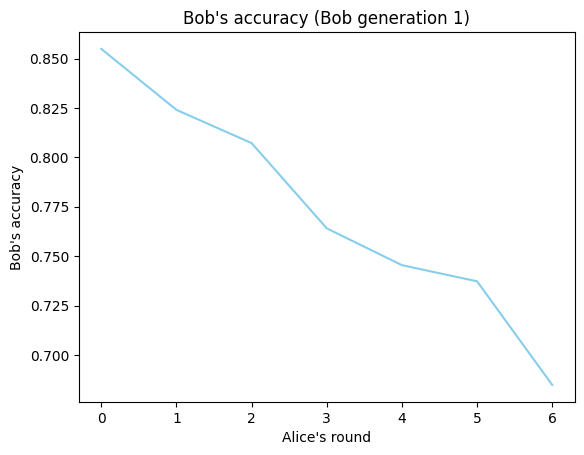

In [13]:
#visualization_alice_config_ids = [1, 5, 6, 7, 8, 9, 10]
visualization_alice_config_ids = [1, 5, 6, 7, 8, 9, 11]
round_ns = []
correct_fractions = []
with sqlite3.connect(database_path) as conn:
    for alice_config_id in visualization_alice_config_ids:
        cursor = conn.cursor()

        cursor.execute("""
SELECT round_n from alice_config
WHERE oid = ?
""", [alice_config_id])
        round_n = cursor.fetchone()[0]
        round_ns.append(round_n)


        cursor.execute("""
SELECT COUNT(alice_llm_response.oid) from alice_query_to_llm, alice_llm_response
WHERE alice_query_to_llm.oid = alice_llm_response.query_id and alice_llm_response.is_correct = false and alice_config_id = ?;
""", [alice_config_id])
        count_bad_generations = cursor.fetchone()[0]
        cursor.execute("""
SELECT COUNT(bob_llm_response.oid)
FROM alice_query_to_llm, alice_llm_response, bob_query_to_llm, bob_llm_response
WHERE
    alice_query_to_llm.oid = alice_llm_response.query_id and alice_llm_response.is_correct = true and 
    bob_query_to_llm.generated_program_id = correct_program_id and bob_llm_response.query_id = bob_query_to_llm.oid and 
    bob_llm_response.is_correct = True and alice_config_id = ?;
""", [alice_config_id])
        count_correct = cursor.fetchone()[0]
        cursor.execute("""
SELECT COUNT(bob_llm_response.oid)
FROM alice_query_to_llm, alice_llm_response, bob_query_to_llm, bob_llm_response
WHERE
    alice_query_to_llm.oid = alice_llm_response.query_id and alice_llm_response.is_correct = true and 
    bob_query_to_llm.generated_program_id = correct_program_id and bob_llm_response.query_id = bob_query_to_llm.oid and 
    alice_config_id = ?;
""", [alice_config_id])
        count_all = cursor.fetchone()[0]
        correct_fraction = float(count_correct) / (count_all+count_bad_generations)
        correct_fractions.append(correct_fraction)

plt.plot(round_ns, correct_fractions, color='skyblue')
plt.xlabel("Alice's round")
plt.ylabel("Bob's accuracy")
plt.title("Bob's accuracy (Bob generation 1)")

In [14]:
program_ids_to_example_ids = dict()

with sqlite3.connect(database_path) as conn:
    cursor = conn.cursor()
    all_difficulties = []
    programs_by_difficulty = defaultdict(set)
    for i in range(len(visualization_alice_config_ids)):
        round_n = round_ns[i]
        alice_config_id = visualization_alice_config_ids[i]
        print(f"Round: {round_n}")
        
        difficulties = []
        cursor.execute("""
SELECT correct_program_id, computed_difficulty, alice_query_to_llm.example_id from alice_query_to_llm, alice_llm_response, evaluated_program
WHERE
    alice_query_to_llm.oid = alice_llm_response.query_id and alice_llm_response.is_correct = true and 
    evaluated_program.generated_program_id = correct_program_id and alice_config_id = ?;
""", [alice_config_id])
        program_ids_and_difficulties_and_example_ids = cursor.fetchall()
        difficulties = [y[1] for y in program_ids_and_difficulties_and_example_ids]
        all_difficulties.append(difficulties)
        for program_id, difficulty, example_id in program_ids_and_difficulties_and_example_ids:
            programs_by_difficulty[difficulty].add(program_id)
            program_ids_to_example_ids[program_id] = example_id

Round: 0
Round: 1
Round: 2
Round: 3
Round: 4
Round: 5
Round: 6


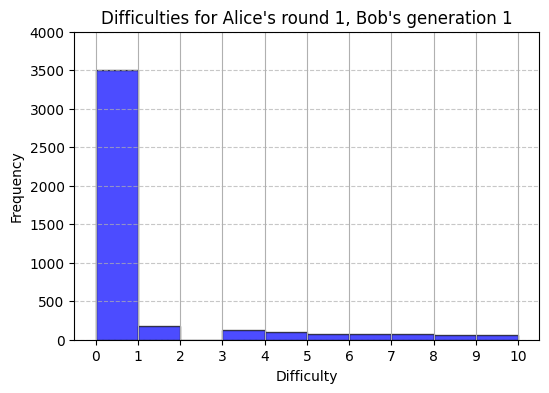

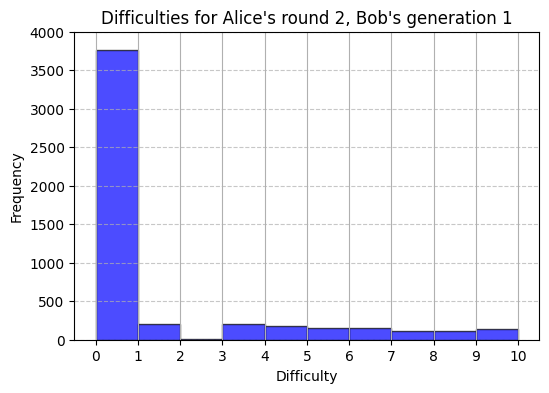

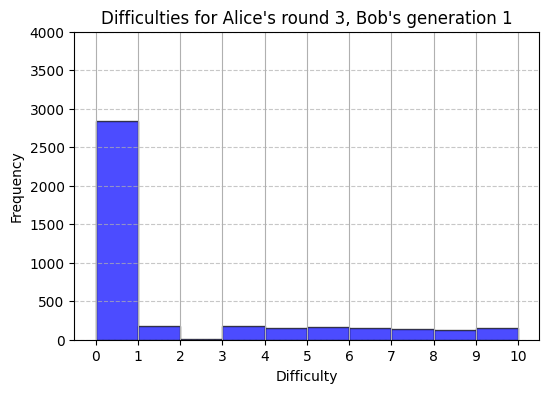

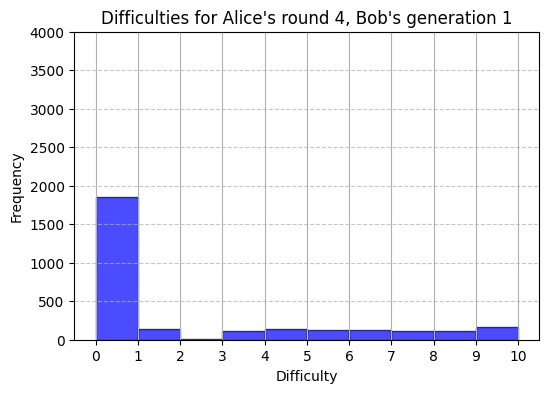

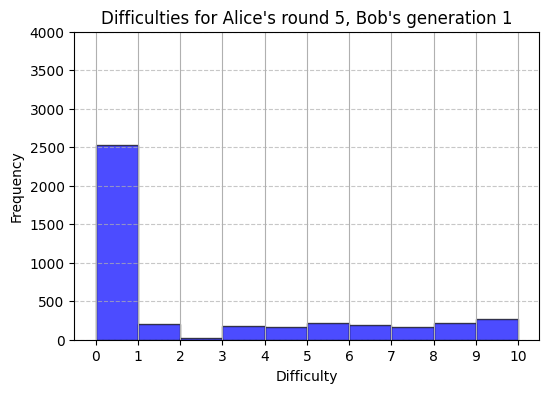

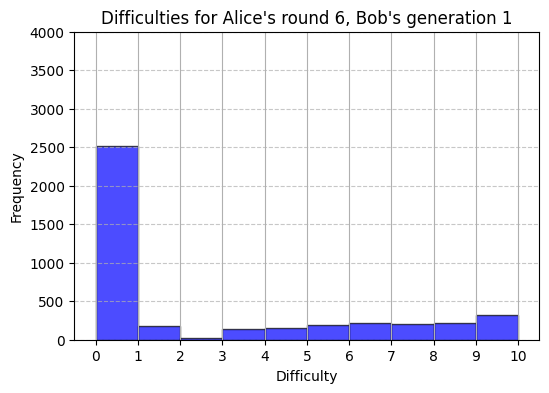

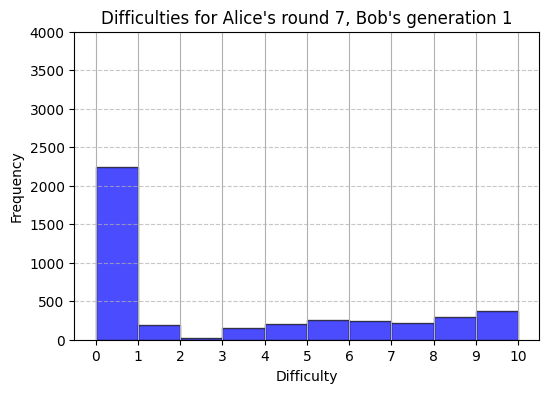

In [15]:
for round_n, difficulties in enumerate(all_difficulties):
    plt.figure(figsize=(6, 4))
    plt.hist(difficulties, bins=10, alpha=0.7, color='blue', edgecolor='black', range=(0, 10))
    plt.xticks(range(0, 11))
    #plt.yticks(range(0, 3500, 500))
    plt.ylim(0, 4000)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.title(f"Difficulties for Alice's round {round_n+1}, Bob's generation 1")
    plt.xlabel("Difficulty")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

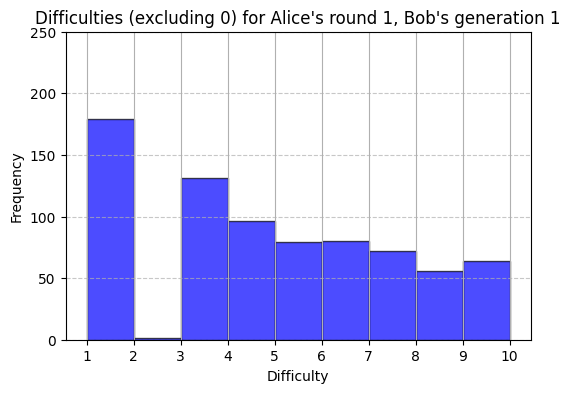

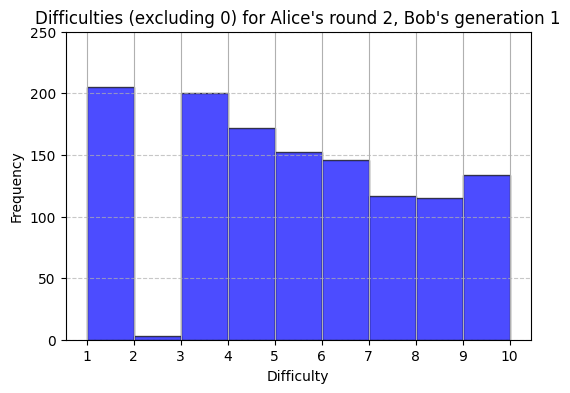

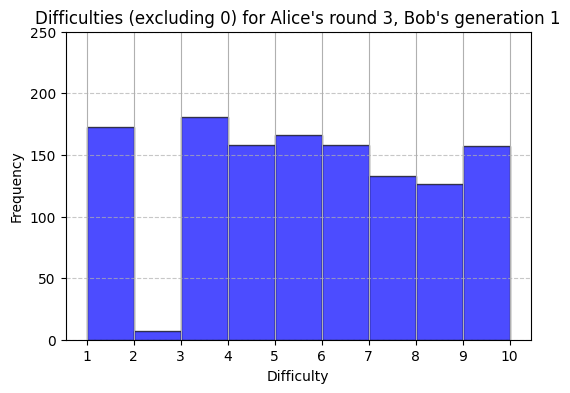

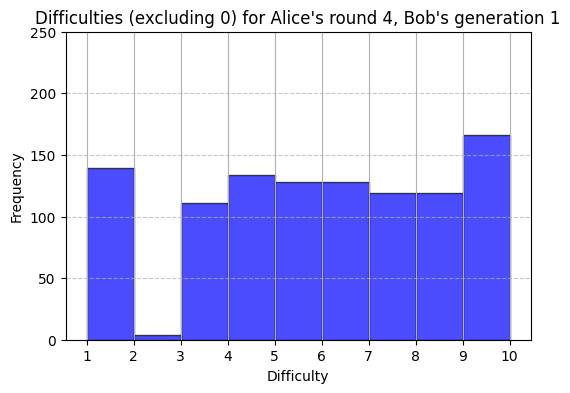

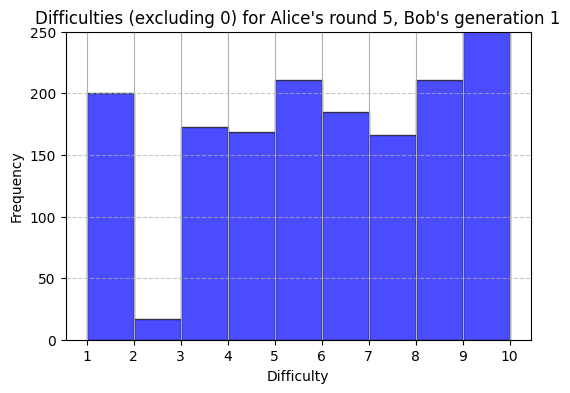

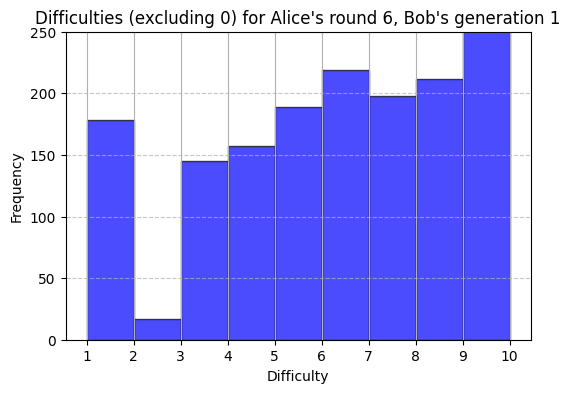

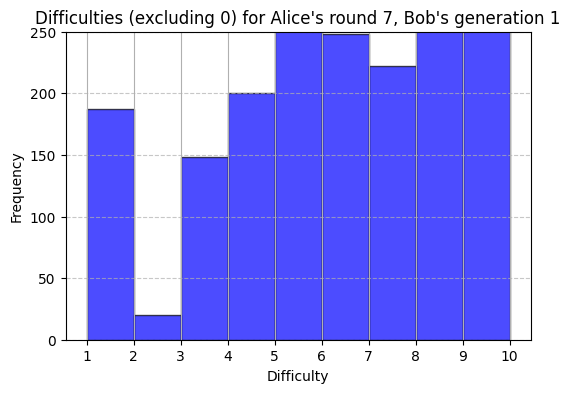

In [16]:
for round_n, difficulties in enumerate(all_difficulties):
    plt.figure(figsize=(6, 4))
    difficulties_no_zero = [d for d in difficulties if d != 0]
    plt.hist(difficulties_no_zero, bins=9, alpha=0.7, color='blue', edgecolor='black', range=(1, 10))
    plt.xticks(range(1, 11))
    plt.ylim(0, 250)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.title(f"Difficulties (excluding 0) for Alice's round {round_n+1}, Bob's generation 1")
    plt.xlabel("Difficulty")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

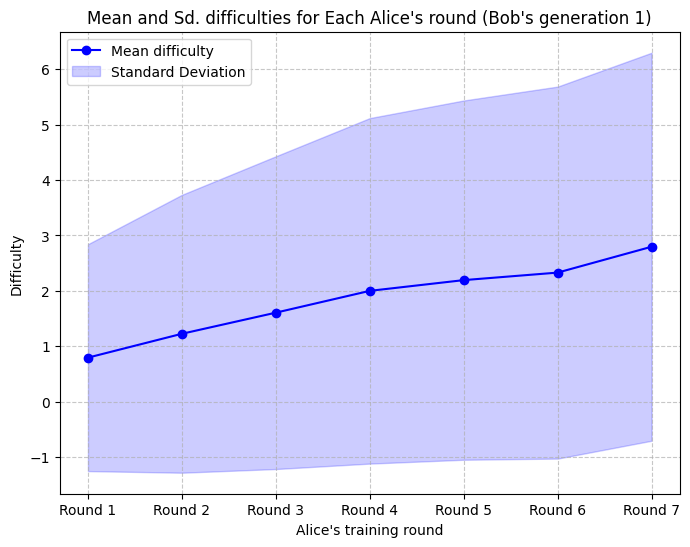

In [71]:
mean_difficulties = [np.mean(difficulties) for difficulties in all_difficulties]
sd_difficulties = [np.std(difficulties) for difficulties in all_difficulties]

# Plot the line graph with shading
plt.figure(figsize=(8, 6))
plt.plot(round_ns, mean_difficulties, marker='o', label='Mean difficulty', color='blue')
plt.fill_between(round_ns,
                 [m - s for m, s in zip(mean_difficulties, sd_difficulties)],  # Mean - Std Dev
                 [m + s for m, s in zip(mean_difficulties, sd_difficulties)],  # Mean + Std Dev
                 color='blue', alpha=0.2, label='Standard Deviation')
plt.xticks(round_ns, [f"Round {i+1}" for i in round_ns])  # Label x-axis
plt.title("Mean and Sd. difficulties for Each Alice's round (Bob's generation 1)")
plt.xlabel("Alice's training round")
plt.ylabel("Difficulty")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.savefig(Path("./", "mean_and_sd_difficulty_bob_generation_0.png"), format="png")
plt.show()

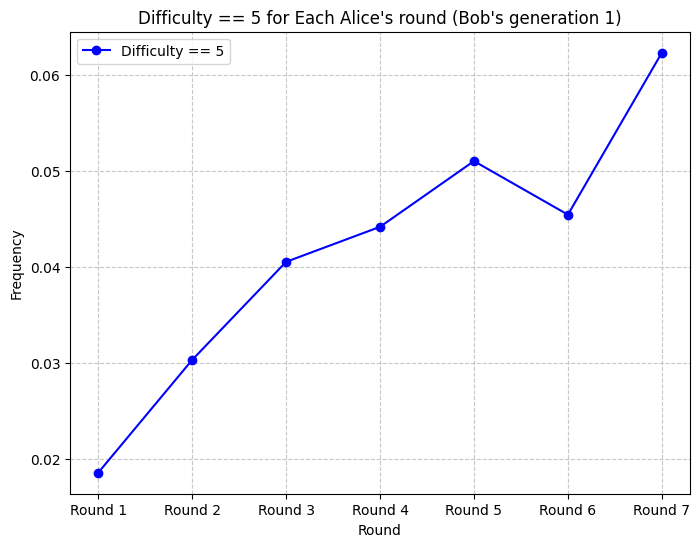

[np.float64(0.01856203007518797), np.float64(0.030321164971075204), np.float64(0.04054714215925745), np.float64(0.04419889502762431), np.float64(0.05105250423421244), np.float64(0.04546547991339909), np.float64(0.062351261304140884)]


In [18]:
difficulties_eq_5 = [sum(np.array(difficulties) == 5) / len(difficulties) for difficulties in all_difficulties]
plt.figure(figsize=(8, 6))
plt.plot(round_ns, difficulties_eq_5, marker='o', label='Difficulty == 5', color='blue')
plt.xticks(round_ns, [f"Round {i+1}" for i in round_ns])  # Label x-axis
plt.title("Difficulty == 5 for Each Alice's round (Bob's generation 1)")
plt.xlabel("Round")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()
print(difficulties_eq_5)

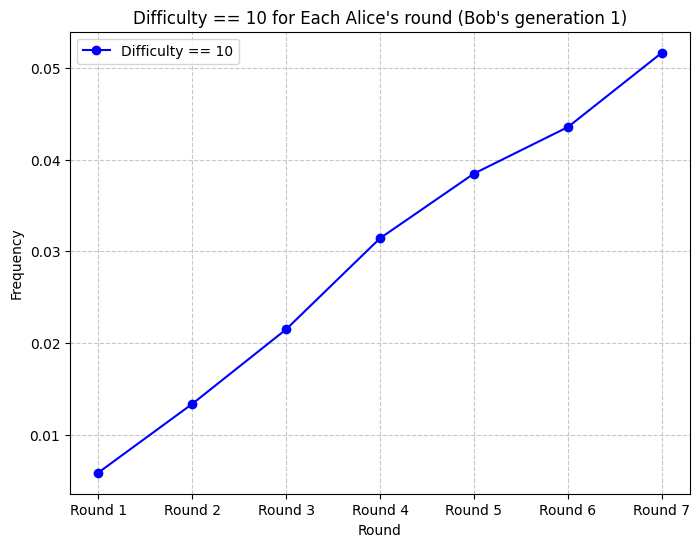

[np.float64(0.0058740601503759395), np.float64(0.01336525034909236), np.float64(0.02149487054225696), np.float64(0.03142265193370166), np.float64(0.038470844422937335), np.float64(0.04354101515515997), np.float64(0.05164207520228463)]


In [68]:
difficulties_eq_10 = [sum(np.array(difficulties) == 10) / len(difficulties) for difficulties in all_difficulties]
plt.figure(figsize=(8, 6))
plt.plot(round_ns, difficulties_eq_10, marker='o', label='Difficulty == 10', color='blue')
plt.xticks(round_ns, [f"Round {i+1}" for i in round_ns])  # Label x-axis
plt.title("Difficulty == 10 for Each Alice's round (Bob's generation 1)")
plt.xlabel("Round")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.savefig(Path("./", "difficulty_10_bob_generation_0.png"), format="png")
plt.show()
print(difficulties_eq_10)

In [282]:
# Finetuning dataset for Alice's generation

In [20]:
def rebalance_dataset(dataset_by_difficulty, difficulty_level_theshold=5, easy_examples_fraction=0.1):
    rebalanced_dataset_by_difficulty = defaultdict(list)
    num_hard_examples = 0
    num_easy_examples = 0
    easy_examples = defaultdict(list)
    for d, v in dataset_by_difficulty.items():
        if d >= difficulty_level_theshold:
            num_hard_examples += len(v)
            rebalanced_dataset_by_difficulty[d] = v
        else:
            num_easy_examples += len(v)
    hard_examples_fraction = 1.0 - easy_examples_fraction
    num_easy_examples_to_add = int((easy_examples_fraction/hard_examples_fraction) * num_hard_examples)
    num_easy_examples_to_add = min(num_easy_examples_to_add, num_easy_examples)
    print(f"Original examples: {num_hard_examples + num_easy_examples}, easy: {num_easy_examples}, hard: {num_hard_examples}")
    print(f"Rebalanced examples: {num_hard_examples+num_easy_examples_to_add}, easy: {num_easy_examples_to_add}, hard: {num_hard_examples}")

    # go in a round robin way through difficulty levels
    d = difficulty_level_theshold - 1
    while (num_easy_examples_to_add > 0):
        if d < 0:
            d = difficulty_level_theshold - 1
        if len(easy_examples[d]) == 0:
            v = dataset_by_difficulty[d]
            if len(v) == 0:
                d -= 1
                continue
            v = list(v.copy())
            random.shuffle(v)
            easy_examples[d] = v
        example = easy_examples[d].pop()
        rebalanced_dataset_by_difficulty[d].append(example)
        num_easy_examples_to_add -= 1
        d -= 1

    rebalanced_dataset = []
    for v in rebalanced_dataset_by_difficulty.values():
        rebalanced_dataset.extend(v)
    random.shuffle(rebalanced_dataset)
    return rebalanced_dataset_by_difficulty, rebalanced_dataset

# More aggressive dataset rebalancing
# downsample examples of difficulty below 5 to 1/10 of the dataset

rebalanced_alice_finetuning_examples_by_difficulty, rebalanced_alice_finetuning_examples = rebalance_dataset(programs_by_difficulty)

Original examples: 13843, easy: 12241, hard: 1602
Rebalanced examples: 1780, easy: 178, hard: 1602


In [284]:
rebalanced_alice_finetuning_examples_by_difficulty_for_difficulty_prediction, rebalanced_alice_finetuning_examples_for_difficulty_prediction = rebalance_dataset(programs_by_difficulty, easy_examples_fraction=0.5)

Original examples: 13843, easy: 12241, hard: 1602
Rebalanced examples: 3204, easy: 1602, hard: 1602


In [285]:
program_ids_to_query = set()
program_ids_to_query = program_ids_to_query.union(rebalanced_alice_finetuning_examples)
program_ids_to_query = program_ids_to_query.union(rebalanced_alice_finetuning_examples_for_difficulty_prediction)

with sqlite3.connect(database_path) as conn:
    cursor = conn.cursor()
    cursor.execute(f"""
SELECT correct_program_id, code, function_name, alice_llm_response.llm_response 
FROM alice_llm_response, alice_query_to_llm, example 
WHERE alice_llm_response.query_id = alice_query_to_llm.oid and alice_query_to_llm.example_id = example.oid and is_correct = True and
correct_program_id in ({', '.join(['?']*len(program_ids_to_query))});
""", list(program_ids_to_query))
    finetuning_examples = defaultdict(list)
    for program_id, code, function_name, target_llm_response in cursor.fetchall():
        finetuning_examples[program_id].append({"code": code, "function_name": function_name, "target_llm_response": target_llm_response})
    finetuning_examples_one = dict()
    for program_id, examples in finetuning_examples.items():
        finetuning_examples_one[program_id] = random.choice(examples)
    for difficulty, program_ids in programs_by_difficulty.items():
        for program_id in program_ids:
            if program_id in finetuning_examples_one:
                finetuning_examples_one[program_id]["difficulty_level"] = difficulty

rebalanced_alice_finetuning_examples = [finetuning_examples_one[program_id] for program_id in rebalanced_alice_finetuning_examples]
rebalanced_alice_finetuning_examples_for_difficulty_prediction = [finetuning_examples_one[program_id] for program_id in rebalanced_alice_finetuning_examples_for_difficulty_prediction]

In [286]:
finetuning_for_alice_round_n = round_ns[-1]
finetuning_for_alice_run_n = 0
finetuning_for_alice_filename = f"./finetuning_data_for_alice/finetuning_data_for_alice_{finetuning_for_alice_round_n}_train_{finetuning_for_alice_run_n}.jsonl"

In [287]:
finetuning_for_alice_filename

'./finetuning_data_for_alice/finetuning_data_for_alice_6_train_0.jsonl'

In [288]:
finetuning_for_alice_system_message = \
"""You are an expert computer scientist. Your task is to take a Python 3.10 program and write a similar program which is not semantically equivalent, which means that there must exist at least a diverging input example such that the original program and your program either produce different outputs or exceptions, or one halts and the other one does not halt. In addition to a program, you need to produce a diverging input example. Start by carefully analyzing the original program and think of how an example would propagate through it from the input to the return value, considering how to modify the program in order to elicit a different behavior. Make sure that the return values or exceptions raised by your program are picklable.
The original program and your program will be used in a test to evaluate the skill of an expert computer scientist who will have to produce a diverging example (not necessarily the same as yours), so make sure that the difference you introduce are not very easy to understand. You will be given a difficulty level from 0 (easiest) to 10 (hardest) to target. E.g. difficulty level 0 means that an expert computer scientist in the bottom decile or above should be able to find a diverging example, difficulty level 9 means that only an expert computer scientist in the top decile should be able to find a diverging example, and difficulty level 10 means that only the top 1% or less of expert computer scientists should be able to find a diverging example.
Think step by step before writing your program. Use the following Markdown format, making sure that the following sections are delimited by level 1 headings, since they will have to be automatically parsed:
# Analysis
step by step analysis. This section can include sub-headings and code blocks
# Generated program
your program inside a Python code block. Do not change the name or signature of the entry point function
# Diverging input example
your diverging input example as a Python dictionary inside a Python code block
For instance, if the entry point function takes two parameters a and b and your diverging example is a="foo" and b=42, write:
```python
{
  "a": "foo",
  "b": 42
}
```
do not write the expected outputs
"""

def finetuning_for_alice_user_message_fn_0(example, difficulty_level=None):
    if difficulty_level == None:
        difficulty_level = example["difficulty_level"]
    return f"""Difficulty level: {difficulty_level}
Entry point function: {example["function_name"]}

```python
{example["code"]}
```"""

def finetuning_for_alice_assistant_message_fn_0(example):
    return example["target_llm_response"]

finetuning_for_alice_for_difficulty_prediction_user_message_1 = """Predict the difficulty level of the instance. Just write "Difficulty level: D" where D is your prediction, do not write anything else."""

def finetuning_for_alice_for_difficulty_prediction_assistant_message_fn_1(example):
    return f"""Difficulty level: {example["difficulty_level"]}"""

In [289]:
add_difficulty_prediction_examples = True

with open(finetuning_for_alice_filename, "w") as out_fs:
    for example in rebalanced_alice_finetuning_examples:
        messages = [{"role": "system", "content": finetuning_for_alice_system_message}, 
                    {"role": "user", "content": finetuning_for_alice_user_message_fn_0(example)},
                    {"role": "assistant", "content": finetuning_for_alice_assistant_message_fn_0(example)}]
        example_dict = {"messages": messages}
        print(json.dumps(example_dict), file=out_fs)
    if add_difficulty_prediction_examples:
        for example in rebalanced_alice_finetuning_examples_for_difficulty_prediction:
            messages = [{"role": "system", "content": finetuning_for_alice_system_message}, 
                        {"role": "user", "content": finetuning_for_alice_user_message_fn_0(example, difficulty_level="Any")},
                        {"role": "assistant", "content": finetuning_for_alice_assistant_message_fn_0(example), "weight": 0},
                        {"role": "user", "content": finetuning_for_alice_for_difficulty_prediction_user_message_1},
                        {"role": "assistant", "content": finetuning_for_alice_for_difficulty_prediction_assistant_message_fn_1(example)}]
            example_dict = {"messages": messages}
            print(json.dumps(example_dict), file=out_fs)

In [290]:
# Validate fine-tuning data files

data_path = finetuning_for_alice_filename

with open(data_path, 'r', encoding='utf-8') as f:
    finetune_dataset = [json.loads(line) for line in f]

# Initial dataset stats
print("Num examples:", len(finetune_dataset))
print("First example:")
for message in finetune_dataset[0]["messages"]:
    print(message)

Num examples: 4984
First example:
{'role': 'system', 'content': 'You are an expert computer scientist. Your task is to take a Python 3.10 program and write a similar program which is not semantically equivalent, which means that there must exist at least a diverging input example such that the original program and your program either produce different outputs or exceptions, or one halts and the other one does not halt. In addition to a program, you need to produce a diverging input example. Start by carefully analyzing the original program and think of how an example would propagate through it from the input to the return value, considering how to modify the program in order to elicit a different behavior. Make sure that the return values or exceptions raised by your program are picklable.\nThe original program and your program will be used in a test to evaluate the skill of an expert computer scientist who will have to produce a diverging example (not necessarily the same as yours), s

In [297]:
for e in finetune_dataset:
    print_this_one = False
    for message in e["messages"]:
        if "Difficulty level: 9" in message['content']:
            print_this_one = True
            break
    if print_this_one:
        print("\n\n".join([str(m) for m in e["messages"]]))
        break    

{'role': 'system', 'content': 'You are an expert computer scientist. Your task is to take a Python 3.10 program and write a similar program which is not semantically equivalent, which means that there must exist at least a diverging input example such that the original program and your program either produce different outputs or exceptions, or one halts and the other one does not halt. In addition to a program, you need to produce a diverging input example. Start by carefully analyzing the original program and think of how an example would propagate through it from the input to the return value, considering how to modify the program in order to elicit a different behavior. Make sure that the return values or exceptions raised by your program are picklable.\nThe original program and your program will be used in a test to evaluate the skill of an expert computer scientist who will have to produce a diverging example (not necessarily the same as yours), so make sure that the difference yo

In [191]:
from openai import OpenAI

oai_key_file = "../oai_key"

if os.environ.get("OPENAI_API_KEY", "") == "":
    with open(oai_key_file, "r") as in_fs:
        os.environ["OPENAI_API_KEY"] = in_fs.read().strip()

In [192]:
# Upload fine-tuning data files to OpenAI

with open(finetuning_for_alice_filename, "rb") as in_fs:
    client = OpenAI()
    client.files.create(file=in_fs, purpose="fine-tune")

In [193]:
# Finetuning dataset with DPO for Alice's generation

In [219]:
def extract_dpo_finetuning_pairs(dataset_by_difficulty, difficulty_level_theshold=5):
    easy_program_ids = []
    hard_program_ids = []
    easy_example_ids_to_program_ids = defaultdict(list)
    for d, v in dataset_by_difficulty.items():
        if d >= difficulty_level_theshold:
            hard_program_ids.extend(v)
        else:
            easy_program_ids.extend(v)
            for program_id in v:
                example_id = program_ids_to_example_ids[program_id]
                easy_example_ids_to_program_ids[example_id].append(program_id)
    example_pairs = []
    for hard_program_id in hard_program_ids:
        example_id = program_ids_to_example_ids[hard_program_id]
        if len(easy_example_ids_to_program_ids[example_id]) > 0:
            easy_program_id = random.choice(easy_example_ids_to_program_ids[example_id])
            example_pairs.append((hard_program_id, easy_program_id, example_id))
    print(f"DPO example pairs: {len(example_pairs)} at threshold difficulty {difficulty_level_theshold}")
    return example_pairs

In [220]:
dpo_example_pairs = extract_dpo_finetuning_pairs(programs_by_difficulty)

DPO example pairs: 1221 at threshold difficulty 5


In [236]:
program_ids_to_query =  [dpo_example_pair[0] for dpo_example_pair in dpo_example_pairs]
program_ids_to_query += [dpo_example_pair[1] for dpo_example_pair in dpo_example_pairs]
program_ids_to_query = set(program_ids_to_query)

with sqlite3.connect(database_path) as conn:
    cursor = conn.cursor()
    cursor.execute(f"""
SELECT correct_program_id, code, function_name, alice_llm_response.llm_response 
FROM alice_llm_response, alice_query_to_llm, example 
WHERE alice_llm_response.query_id = alice_query_to_llm.oid and alice_query_to_llm.example_id = example.oid and is_correct = True and
correct_program_id in ({', '.join(['?']*len(program_ids_to_query))});
""", list(program_ids_to_query))
    finetuning_examples = defaultdict(list)
    for program_id, code, function_name, target_llm_response in cursor.fetchall():
        finetuning_examples[program_id].append({"code": code, "function_name": function_name, "target_llm_response": target_llm_response})
    finetuning_examples_one = dict()
    for program_id, examples in finetuning_examples.items():
        finetuning_examples_one[program_id] = random.choice(examples)
    for difficulty, program_ids in programs_by_difficulty.items():
        for program_id in program_ids:
            if program_id in finetuning_examples_one:
                finetuning_examples_one[program_id]["difficulty_level"] = difficulty

finetuning_examples_dpo = []
for hard_program_id, easy_program_id, example_id in dpo_example_pairs:
    hard_program = finetuning_examples_one[hard_program_id]
    easy_program = finetuning_examples_one[easy_program_id]
    example_pair = {"code": hard_program["code"], 
                    "function_name": hard_program["function_name"],
                    "target_llm_response": hard_program["target_llm_response"],
                    "easy_target_llm_response": easy_program["target_llm_response"],
                    "difficulty_level": hard_program["difficulty_level"],
                    "easy_difficulty_level": easy_program["difficulty_level"]}
    finetuning_examples_dpo.append(example_pair)

In [237]:
finetuning_for_alice_dpo_filename = f"./finetuning_data_for_alice/finetuning_data_for_alice_dpo_{finetuning_for_alice_round_n}_train_{finetuning_for_alice_run_n}.jsonl"
print(finetuning_for_alice_dpo_filename)

./finetuning_data_for_alice/finetuning_data_for_alice_dpo_5_train_0.jsonl


In [240]:
with open(finetuning_for_alice_dpo_filename, "w") as out_fs:
    for example in finetuning_examples_dpo:
        messages = [{"role": "system", "content": finetuning_for_alice_system_message}, 
                    {"role": "user", "content": finetuning_for_alice_user_message_fn_0(example)}]
        preferred_output = [{"role": "assistant", "content": finetuning_for_alice_assistant_message_fn_0(example)}]
        easy_example = example.copy()
        easy_example["target_llm_response"] = example["easy_target_llm_response"]
        non_preferred_output = [{"role": "assistant", "content": finetuning_for_alice_assistant_message_fn_0(easy_example)}]
        example_dict = {"input": {"messages": messages}, "preferred_output": preferred_output, "non_preferred_output": non_preferred_output}
        print(json.dumps(example_dict), file=out_fs)

In [241]:
# Upload DPO fine-tuning data files for Alice to OpenAI

with open(finetuning_for_alice_dpo_filename, "rb") as in_fs:
    client = OpenAI()
    client.files.create(file=in_fs, purpose="fine-tune")

In [21]:
# Finetuning dataset for Bob's evaluation

In [23]:
rebalanced_bob_finetuning_examples_by_difficulty, rebalanced_bob_finetuning_examples = rebalance_dataset(programs_by_difficulty)

program_ids_to_query = set()
program_ids_to_query = program_ids_to_query.union(rebalanced_bob_finetuning_examples)

with sqlite3.connect(database_path) as conn:
    cursor = conn.cursor()
    cursor.execute(f"""
SELECT correct_program_id, code, function_name, alice_llm_response.llm_response, generated_program.program, 
bob_llm_response.llm_response 
FROM alice_llm_response, alice_query_to_llm, example, generated_program, bob_query_to_llm, bob_llm_response 
WHERE alice_llm_response.query_id = alice_query_to_llm.oid and alice_query_to_llm.example_id = example.oid and
alice_llm_response.is_correct = True and generated_program.oid = correct_program_id and
bob_query_to_llm.generated_program_id = correct_program_id and bob_query_to_llm.oid = bob_llm_response.query_id and 
bob_llm_response.is_correct = True and
correct_program_id in ({', '.join(['?']*len(program_ids_to_query))});
""", list(program_ids_to_query))
    finetuning_examples = defaultdict(list)
    for program_id, code, function_name, alice_llm_response, generated_program, bob_llm_response in cursor.fetchall():
        finetuning_examples[program_id].append({"code": code, "function_name": function_name, "alice_llm_response": alice_llm_response,
                                               "generated_program": generated_program, "bob_llm_response": bob_llm_response})
    finetuning_examples_one = dict()
    for program_id, examples in finetuning_examples.items():
        finetuning_examples_one[program_id] = random.choice(examples)
    for difficulty, program_ids in programs_by_difficulty.items():
        for program_id in program_ids:
            if program_id in finetuning_examples_one:
                finetuning_examples_one[program_id]["difficulty_level"] = difficulty

rebalanced_bob_finetuning_examples = [finetuning_examples_one[program_id] for program_id in rebalanced_bob_finetuning_examples if program_id in finetuning_examples_one]

Original examples: 13843, easy: 12241, hard: 1602
Rebalanced examples: 1780, easy: 178, hard: 1602


In [35]:
finetuning_for_bob_generation_n = 0
finetuning_for_bob_round_n = round_ns[-1]
finetuning_for_bob_run_n = 0
finetuning_for_bob_filename = f"./finetuning_data_for_bob/finetuning_data_for_bob_{finetuning_for_bob_generation_n}_train_{finetuning_for_bob_round_n}_{finetuning_for_bob_run_n}.jsonl"

In [36]:
finetuning_for_bob_filename

'./finetuning_data_for_bob/finetuning_data_for_bob_0_train_6_0.jsonl'

In [37]:
finetuning_for_bob_system_message = \
"""You are an expert computer scientist. Your task is to take two Python 3.10 programs and determine whether or not they are semantically equivalent. Two programs are semantically equivalent if there exists no diverging input examples such that the original program and your program either produce different outputs or exceptions, or one halts and the other one does not halt. If you determine that the two programs are not semantically equivalent, you also need to produce a diverging input example. Start by carefully analyzing the two programs and think of how an example would propagate through them from the input to the return value, considering whether it could elicit a different behaviors. 
Think step by step before writing your program. Use the following Markdown format, making sure that the following sections are delimited by level 1 headings, since they will have to be automatically parsed:
# Analysis
step by step analysis. This section can include sub-headings and code blocks
# Equivalent?
Yes or No
# Diverging input example
your diverging input example as a Python dictionary inside a Python code block, or nothing if the two programs are equivalent.
For instance, if the entry point function takes two parameters a and b and your diverging example is a="foo" and b=42, write:
```python
{
  "a": "foo",
  "b": 42
}
```
do not write the expected outputs
"""

def finetuning_for_bob_user_message_fn_0(example, difficulty_level=None):
    return f"""Entry point function: {example["function_name"]}

Program 1:
```python
{example["code"]}
```

Program 2:
```python
{example["generated_program"]}
```"""

def finetuning_for_bob_assistant_message_fn_0(example):
    return example["bob_llm_response"]

In [38]:
with open(finetuning_for_bob_filename, "w") as out_fs:
    for example in rebalanced_bob_finetuning_examples:
        messages = [{"role": "system", "content": finetuning_for_bob_system_message}, 
                    {"role": "user", "content": finetuning_for_bob_user_message_fn_0(example)},
                    {"role": "assistant", "content": finetuning_for_bob_assistant_message_fn_0(example)}]
        example_dict = {"messages": messages}
        print(json.dumps(example_dict), file=out_fs)

In [39]:
# Validate fine-tuning data files

data_path = finetuning_for_bob_filename

with open(data_path, 'r', encoding='utf-8') as f:
    finetune_dataset = [json.loads(line) for line in f]

# Initial dataset stats
print("Num examples:", len(finetune_dataset))
print("First example:")
for message in finetune_dataset[0]["messages"]:
    print(message)

Num examples: 1639
First example:
{'role': 'system', 'content': 'You are an expert computer scientist. Your task is to take two Python 3.10 programs and determine whether or not they are semantically equivalent. Two programs are semantically equivalent if there exists no diverging input examples such that the original program and your program either produce different outputs or exceptions, or one halts and the other one does not halt. If you determine that the two programs are not semantically equivalent, you also need to produce a diverging input example. Start by carefully analyzing the two programs and think of how an example would propagate through them from the input to the return value, considering whether it could elicit a different behaviors. \nThink step by step before writing your program. Use the following Markdown format, making sure that the following sections are delimited by level 1 headings, since they will have to be automatically parsed:\n# Analysis\nstep by step anal

In [41]:
from openai import OpenAI

oai_key_file = "../oai_key"

if os.environ.get("OPENAI_API_KEY", "") == "":
    with open(oai_key_file, "r") as in_fs:
        os.environ["OPENAI_API_KEY"] = in_fs.read().strip()

In [42]:
# Upload fine-tuning data files to OpenAI

with open(finetuning_for_bob_filename, "rb") as in_fs:
    client = OpenAI()
    client.files.create(file=in_fs, purpose="fine-tune")

In [43]:
# Finetuning for Bob in DeepSeek-r1 format

In [46]:
finetuning_for_bob_deepseek_filename = f"./finetuning_data_for_bob_deepseek/finetuning_data_for_bob_deepseek_{finetuning_for_bob_generation_n}_train_{finetuning_for_bob_round_n}_{finetuning_for_bob_run_n}.jsonl"

In [47]:
finetuning_for_bob_deepseek_filename

'./finetuning_data_for_bob_deepseek/finetuning_data_for_bob_deepseek_0_train_6_0.jsonl'

In [61]:
finetuning_for_bob_deepseek_preamble = \
"""Your task is to take two Python 3.10 programs and determine whether or not they are semantically equivalent. Two programs are semantically equivalent if there exists no diverging input examples such that the original program and your program either produce different outputs or exceptions, or one halts and the other one does not halt. If you determine that the two programs are not semantically equivalent, you also need to produce a diverging input example. Start by carefully analyzing the two programs and think of how an example would propagate through them from the input to the return value, considering whether it could elicit a different behaviors. 
Think step by step within <think></think> tags before writing your answer. Use the following Markdown format, making sure that the following sections are delimited by level 1 headings, since they will have to be automatically parsed:
<think>
# Analysis
step by step analysis. This section can include sub-headings and code blocks
</think>

# Equivalent?
Yes or No
# Diverging input example
your diverging input example as a Python dictionary inside a Python code block, or nothing if the two programs are equivalent.
For instance, if the entry point function takes two parameters a and b and your diverging example is a="foo" and b=42, write:
```python
{
  "a": "foo",
  "b": 42
}
```
do not write the expected outputs.

"""

def finetuning_for_bob_deepseek_user_message_fn_0(example, difficulty_level=None):
    return finetuning_for_bob_deepseek_preamble + f"""Entry point function: {example["function_name"]}

Program 1:
```python
{example["code"]}
```

Program 2:
```python
{example["generated_program"]}
```"""

def to_bob_deepseek_response_format(x):
    match = re.search(r'(?m)^# Equivalent\?', x) # It should come just after the analysis section
    j = match.start() # Throw exception if it's not there
    cot, answer = x[:j], x[j:]
    return f"<think>\n{cot.strip()}\n</think>\n\n{answer}"

def finetuning_for_deepseek_bob_assistant_message_fn_0(example):
    return to_bob_deepseek_response_format(example["bob_llm_response"])

In [62]:
with open(finetuning_for_bob_deepseek_filename, "w") as out_fs:
    for example in rebalanced_bob_finetuning_examples:
        messages = [{"role": "user", "content": finetuning_for_bob_deepseek_user_message_fn_0(example)},
                    {"role": "assistant", "content": finetuning_for_deepseek_bob_assistant_message_fn_0(example)}]
        example_dict = {"messages": messages}
        print(json.dumps(example_dict), file=out_fs)

In [63]:
# Validate fine-tuning data files

data_path = finetuning_for_bob_deepseek_filename

with open(data_path, 'r', encoding='utf-8') as f:
    finetune_dataset = [json.loads(line) for line in f]

# Initial dataset stats
print("Num examples:", len(finetune_dataset))
print("First example:")
for message in finetune_dataset[0]["messages"]:
    print(message)

Num examples: 1639
First example:
{'role': 'user', 'content': 'Your task is to take two Python 3.10 programs and determine whether or not they are semantically equivalent. Two programs are semantically equivalent if there exists no diverging input examples such that the original program and your program either produce different outputs or exceptions, or one halts and the other one does not halt. If you determine that the two programs are not semantically equivalent, you also need to produce a diverging input example. Start by carefully analyzing the two programs and think of how an example would propagate through them from the input to the return value, considering whether it could elicit a different behaviors. \nThink step by step within <think></think> tags before writing your answer. Use the following Markdown format, making sure that the following sections are delimited by level 1 headings, since they will have to be automatically parsed:\n<think>\n# Analysis\nstep by step analysis

In [41]:
from openai import OpenAI

oai_key_file = "../oai_key"

if os.environ.get("OPENAI_API_KEY", "") == "":
    with open(oai_key_file, "r") as in_fs:
        os.environ["OPENAI_API_KEY"] = in_fs.read().strip()

In [42]:
# Upload fine-tuning data files to OpenAI

with open(finetuning_for_bob_filename, "rb") as in_fs:
    client = OpenAI()
    client.files.create(file=in_fs, purpose="fine-tune")